# Part 4. DEAP Dataset + Connectivity + SVM

In this part 4, we will focus on feature engineering using connectivity analysis.  Connectivity analysis here refers to the analysis of correlations between different electrodes.

Connectivity analysis is a very useful technique to understand the dynamics of the brain, especially on a very long-duration task.

In this part, we shall extract these connectivities as features.  Then let's try input these features into SVM and see if these features are useful for predicting the four valence-arousal classes that we have obtained from Part 1.

Welcome back to part 4 of this zero-to-hero EEG analysis.

Previously, we learnt that basic Spectral Information (FFT,PSD) can somehow capture the emotion (70% using 5 bands of each electrodes).
However, when we considered the asymetry between 2-electrodes, the accuracy increase to 75%. (We have not yet find the way to mearge the 5 different information)

In brain science, there is a theory that neurons work together. One neuron activate another and so on. This chain (or could be parallel) of activation is in this topic "Connectivity".

This topic is much deeper and harder to simplify (one reason is because it is an on going research) and this tutorial has no intension to explain connectivity theory to you. Therefore, a self-research is a must.

There are multiple ways (a lot of waysss) to measure connectivity. One way is to look at phase.

If the two brain region are working together, their rythm are somewhat synchronize.

OK good, we just match the two electrodes and find the correlation. if it is high then there is connectivity.

Well, that is the basis. In reality, EEG data is highly correlated because each electrode share the same data (an activation is recorded by multiple electrodes). 

One way to counter this is to apply [`surface laplacian`](https://www.youtube.com/watch?v=CodQ5-pmXdQ) method. It is not a perfect method but rather a standard technique. Look into the literature for more detail.

Let's us apply this `surface laplacian` first.

## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [1]:
import numpy as np
import pickle

# this time I will load the Dataset class from `./components/dataset.py`
from components.dataset import Dataset
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset
dataset = Dataset(path, "Valence")

data  = np.array(dataset[:]['data'])
label = np.array(dataset[:]['label']).squeeze()

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  (15360, 32, 672)
Label shape:  (15360,)


Here I only cache the data from the loader.

Loading from cache is faster in my machine.

In [3]:
# Here I can load the data from cache (work a bit faster than loop through the /data/*.dat)
def save(data,filename):
    with open(f'cache/{filename}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    with open(f'cache/{filename}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    return data

# save(data, 'data_valence')
# save(label, 'label_valence')

data = load('data_valence')
label = load('label_valence')

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

# I won't use this `dataset` object anymore. Save a lot of RAM.
del(dataset)

Data shape:  (15360, 32, 672)
Label shape:  (15360,)


## 2. The correlation part

As said in the begining, EEG data is high correlation.

Let's prove that it is true.

**Note: For instace why it should be true is when you blink, the both electrode Fp1 Fp2 measure your blink.*

The easiest way to prove that data are shared between the electrodes is finding correlation. (Wow, i said this word multiple time)

The correlation is somewhat weak term. The number we got from the function meanless unless you compare with another thing. (Confuse? Think of the loss term in Deep Learning, It means nothing unless you compare it in series).

In [22]:
# Here is I calculate correlation step by step

sample = data[0]
# (32, 672)
# sample.shape

# This will has correlation matrix at the end
corr_sample = []

# Get eletrode_a from all electrtodes
for index_a in range(32):
    corr_row = []
    scaler = None
    # Compare electrode_a to all electrodes
    for index_b in range(32):
        electrode_a = sample[index_a]
        electrode_b = sample[index_b]
        # https://numpy.org/doc/stable/reference/generated/numpy.correlate.html
        coeff = np.correlate(electrode_b, electrode_a, mode='valid')
        corr_row.append(coeff)
        if(index_a == index_b): scaler = coeff

    corr_row = np.hstack(corr_row)
    corr_row = corr_row / scaler
    # print(corr_row.shape) => (32,)
    corr_sample.append(corr_row)

corr_sample = np.vstack(corr_sample)
# print(corr_sample.shape) => (32,32)


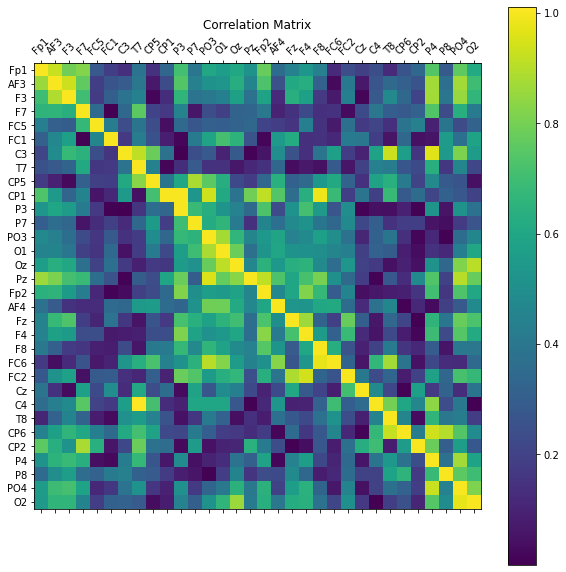

In [23]:
import matplotlib.pyplot as plt

ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
f = plt.figure(figsize=(10, 10))
plt.matshow(abs(corr_sample), fignum=f.number)
plt.xticks(range(len(ch_names)), ch_names, rotation=45)
plt.yticks(range(len(ch_names)), ch_names)
cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix');

The lighter the colour, the greater information they share.

Let's say the Fp1-Fp1 is the maximun information shared = 1. 

Let's see the correation of Fp1 compares another

In [38]:
corr_Fp1 = abs(corr_sample[ch_names.index('Fp1')])

for orderd_index in corr_Fp1.argsort()[::-1]:
    print( corr_Fp1[orderd_index], ch_names[orderd_index]  )

1.0 Fp1
0.9260536 AF3
0.821613 F7
0.7900972 F3
0.77451545 Fp2
0.7598759 PO4
0.74120134 P4
0.70947576 P3
0.61753434 O2
0.6059011 Oz
0.6053959 PO3
0.5621436 O1
0.5293826 F4
0.52142894 Pz
0.44434643 Fz
0.43891737 F8
0.39555243 P7
0.383458 T7
0.3575377 AF4
0.33959383 CP2
0.33204433 CP1
0.2851352 P8
0.28436184 FC5
0.26125258 CP6
0.24175304 C4
0.23949584 FC2
0.1922385 Cz
0.18832019 FC1
0.14312485 CP5
0.13717708 C3
0.12257443 T8
0.120949775 FC6


<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/International_10-20_system_for_EEG-MCN.svg">

Wow. Fp1 and AF3 near recored the same data. It could be the same data if we delayed the electrode_b a bit. But that is question for later.

For now, let's `Surface Laplacian` the data

In `mne`, the function to use is [Current Source Density (CSD)](https://mne.tools/stable/auto_examples/preprocessing/eeg_csd.html?highlight=spatial%20laplacian)

In [44]:
from mne.preprocessing import compute_current_source_density
import mne

# convert data to mne.Epochs
ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 128 #Hz
# https://mne.tools/stable/generated/mne.create_info.html
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
epochs = mne.EpochsArray(data,info)
epochs.set_montage('standard_1020')

# I ran out of RAM
del(data)

epochs_csd = compute_current_source_density(epochs)


Not setting metadata
Not setting metadata
15360 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Fitted sphere radius:         91.4 mm
Origin head coordinates:      1.0 7.3 50.2 mm
Origin device coordinates:    1.0 7.3 50.2 mm


Let's calculate the correlation again with the CSD data

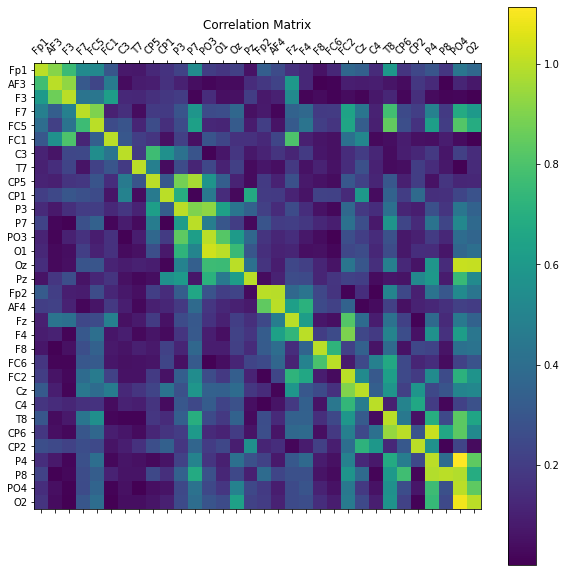

1.0 Fp1
0.9091728367128609 AF3
0.759389404410194 F3
0.5920178061499116 T8
0.5392559727857197 P7
0.5340613955410654 F7
0.5202827941467469 FC5
0.4381353671390498 PO4
0.37820239594916777 O2
0.3728413570877575 FC2
0.34352491605241786 Cz
0.3348395515024905 Fp2
0.2973826567287101 FC1
0.2961737053766444 P4
0.2559005792097564 AF4
0.23574479637355325 CP2
0.21808215111786977 P3
0.21134380579660028 Oz
0.20432248335468034 PO3
0.17871407132280245 O1
0.17723312125906884 P8
0.17168185490339752 CP6
0.16172971870536865 CP1
0.15843781157276257 Fz
0.135495142486162 C4
0.12986920561806914 CP5
0.12646195641373978 FC6
0.12512982219997862 F4
0.07799588594363188 C3
0.07054608369808789 T7
0.054904802951614776 F8
0.05472577976724237 Pz


In [55]:
# Here is I calculate correlation step by step

sample = epochs_csd._data[0]
# (32, 672)
# sample.shape

# This will has correlation matrix at the end
corr_sample = []

# Get eletrode_a from all electrtodes
for index_a in range(32):
    corr_row = []
    scaler = None
    # Compare electrode_a to all electrodes
    for index_b in range(32):
        electrode_a = sample[index_a]
        electrode_b = sample[index_b]
        # https://numpy.org/doc/stable/reference/generated/numpy.correlate.html
        coeff = np.correlate(electrode_b, electrode_a, mode='valid')
        corr_row.append(coeff)
        if(index_a == index_b): scaler = coeff

    corr_row = np.hstack(corr_row)
    corr_row = corr_row / scaler
    # print(corr_row.shape) => (32,)
    corr_sample.append(corr_row)

corr_sample = np.vstack(corr_sample)
# print(corr_sample.shape) => (32,32)

f = plt.figure(figsize=(10, 10))
plt.matshow(abs(corr_sample), fignum=f.number)
plt.xticks(range(len(ch_names)), ch_names, rotation=45)
plt.yticks(range(len(ch_names)), ch_names)
cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix');
plt.show()

corr_Fp1 = abs(corr_sample[ch_names.index('Fp1')])
for orderd_index in corr_Fp1.argsort()[::-1]:
    print( corr_Fp1[orderd_index], ch_names[orderd_index]  )


In [61]:
print('Non CSD sum of correlation coeff:', sum([1.0, 0.9260536, 0.821613, 0.7900972, 0.77451545, 0.7598759, 0.74120134, 0.70947576, 0.61753434, 0.6059011, 0.6053959, 0.5621436, 0.5293826, 0.52142894, 0.44434643, 0.43891737, 0.39555243, 0.383458, 0.3575377, 0.33959383, 0.33204433, 0.2851352, 0.28436184, 0.26125258, 0.24175304, 0.23949584, 0.1922385, 0.18832019, 0.14312485, 0.13717708, 0.12257443, 0.120949775]))

print('CSD sum of correlation coeff:', sum([1.0,0.9091728367128609 ,0.759389404410194 ,0.5920178061499116 ,0.5392559727857197 ,0.5340613955410654 ,0.5202827941467469 ,0.4381353671390498 ,0.37820239594916777 ,0.3728413570877575 ,0.34352491605241786 ,0.3348395515024905 ,0.2973826567287101 ,0.2961737053766444 ,0.2559005792097564 ,0.23574479637355325 ,0.21808215111786977 ,0.21134380579660028 ,0.20432248335468034 ,0.17871407132280245 ,0.17723312125906884 ,0.17168185490339752 ,0.16172971870536865 ,0.15843781157276257 ,0.135495142486162 ,0.12986920561806914 ,0.12646195641373978 ,0.12512982219997862 ,0.07799588594363188 ,0.07054608369808789 ,0.054904802951614776 ,0.05472577976724237]))

Non CSD sum of correlation coeff: 14.872452145000002
CSD sum of correlation coeff: 10.063599232277127


Base on my lazy (because I forget the sum them and I don't want to rerun the tutorial) summation, the CSD has lower the correlation as expected.

Finally, we can do this connectivity thing.

In [63]:
save(epochs_csd, 'epochs_csd_valence')

## 3. Connectivity Analysis

*You can start run from here*

[Emotional EEG Classification using Connectivity Features and Convolutional Neural Networks](https://arxiv.org/pdf/2101.07069.pdf)

Before we jump right into the `connectivity`, let's up think what make sense here.

There are various ways to calculate the connectivity. As shown above, the correlation between electrodes is one of the way.

I will call this `connectivity within trial` and the correlation has the names `Pearson correlation coefficient` ($R^2$).

You could also find the connectivity between different trials which makes sense in the ERP (Event-Related Potential).

Since we are working with Emotion and 5 frequency bands delta (0-4), theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz) is what we are interested (is what I am interested, not nesseary you), we want to do `within trial` and use the result as features for SVM later in the tutorial.

Sure you can see this task as ERP task if you calculate a baseline trial. However, it is not very common to do so.

Let's try the `Pearson correlation coefficient` ($R^2$) using `within trial`

Previously, I did a very simple Correlation matrix using `numpy.correlate` function. Now, it is time to look at the actual equation.

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

$$ C = \frac{Cov[X,Y]}{\sigma_{x}  \sigma_{y}} $$

In this `Pearson correlation coefficient`, we do not look at each freqncy band seperately but rather look at how each brain region interact with each other. For instance, if everytime we are happy then region_a and region_b work together. Hence, a high correlation of region a and b on every happy trial.

The correlation feature of 32*32 channels is 1024 features.

Let's code

In [67]:
import numpy as np
import pickle
import mne
from tqdm.notebook import tqdm

def load(filename):
    with open(f'cache/{filename}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    return data

def save(data,filename):
    with open(f'cache/{filename}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def pearson_correlation(x,y):
    """ x,y denoted the signal_x and signal_y following the equation """
    cov = np.cov(x, y)
    # print(cov)
    # [[ 8806859.74527069  8007149.0906219 ] ==> [[cov_xx, cov_xy]
    # [ 8007149.0906219  10396797.72458848]]      [cov_yx, cov_yy]]
    cov_xy = cov[0,1] # or cov[1,0]
    cov_xx = cov[0,0]
    cov_yy = cov[1,1]
    corr = cov_xy / ( cov_xx**0.5 * cov_yy**0.5  )
    return corr

In [3]:
epochs_csd = load('epochs_csd_valence')
# This will be me calculate Correlation feature with shape (n_trials/n_epochs, 1024)
X = []
for epoch in tqdm(epochs_csd):
    corr_epoch = []
    for index_a in range(32):
        for index_b in range(32):
            p_corr = pearson_correlation(epoch[index_a], epoch[index_b])
            corr_epoch.append(p_corr)
    corr_epoch = np.hstack(corr_epoch)
    # print(corr_epoch.shape) => (1024,)
    X.append(corr_epoch)

X = np.vstack(X)
print(X.shape) # => (15360, 1024)
save(X, 'X_pearson')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 1024)


Let's SVM its

In [5]:
X = load('X_pearson')
y = load('label_valence')
X.shape, y.shape

((15360, 1024), (15360,))

In [6]:
def train_model(X_ori,y_ori, kernel='rbf'):
    # Make a copy because I am paranoid
    X,y = X_ori.copy(), y_ori.copy()

    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    X_shuff,y_shuff = shuffle(X,y)
    model = SVC(kernel=kernel,max_iter=10000)
    cross = cross_val_score(model, X_shuff, y_shuff, cv=3)

    model = SVC(kernel=kernel, max_iter=10000)
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    return model, acc, cross

import time
start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Acc=0.67552 | 3-CV score=0.65885 STD=0.00997| Time spend=991.2590882778168


OMG! It took 991 seconds to finish the run. Well, it was 1024 features. However, This result was a lot better than the `all_asymetry` did.

Next, we are going to calculate the `pearson correlation` of a frequncy content between electrodes.

The function we are going to use [`numpy.fft.fft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html) to calculate the both FFT and obtain phase information (which we will be using later so we going to learn the function now).

Our previous example find correlation between two pure signals which is not wrong. However, if the two signals are actually correlated but delay, it could result in low correlation coefficient. Instead of trying to phase-lock the signal (which is a must in ERP), we are going to convert the signal from Amp-Time domain into Freq-Time domain using FFT instead. (Actually, the PSD function is useable since it is in Freq-Time domain too).

In [71]:
def calculate_fft(signal, sfreq):
    """ signal: can be 1D array of (n_sample,) or 2D array of (n_signal, n_sample)  """
    number_sample = signal.shape[-1]

    # the result will be a complex number. We can obtain the magnitude using `absolute`
    magnitude = np.abs(np.fft.fft(signal))
    # scale the result
    magnitude = magnitude / (number_sample/2)
    # Selecting the range
    magnitude = magnitude.T[:number_sample//2].T
    freq_range = np.fft.fftfreq(number_sample, d=1/sfreq)[:number_sample//2]

    return magnitude, freq_range

X = []
for epoch in tqdm(epochs_csd):
    corr_mag = []
    # (32, 336) (336,)
    mag, f_range = calculate_fft(epoch, 128)
    for index_a in range(32):
        for index_b in range(32):
            p_corr = pearson_correlation(mag[index_a], mag[index_b])
            corr_mag.append(p_corr)
    corr_mag = np.hstack(corr_mag)
    # print(corr_mag.shape)# => (1024,)
    X.append(corr_mag)
    # break

X = np.vstack(X)
print(X.shape) # => (15360, 1024)
save(X, 'X_fft_pearson')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 1024)


In [72]:
X = load('X_fft_pearson')
y = load('label_valence')
print(X.shape, y.shape)

start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

(15360, 1024) (15360,)
	Acc=0.72311 | 3-CV score=0.69538 STD=0.00106| Time spend=617.6518638134003


This time, we bump up the accuray to 72% with nearly 70% of CV score. Sweet!

Next, we are going to explore the connectivity base on Phase of the signal.

In the previous two examples, we kind of ignore the phase. To consider Phase, there are way to measure the connectivity through Phase.

- [Phase Lag Index (PLI)](https://www.youtube.com/watch?v=jdY-qHz6Zo8)

$$ PLI(j,k) = | n^{-1} \Sigma^{n}_{t=1} sign(Im[e^{i (\phi^j - \phi^k) t}])  | $$

- [Inter-site phase clustering (ISPC)](https://www.youtube.com/watch?v=4vwj7t6yDQk)

$$ ISPC(j,k) = | n^{-1} \Sigma^{n}_{t=1} e^{i ( \phi^j - \phi^k)t } |$$

- [phase locking value (PLV)](https://arxiv.org/pdf/2101.07069.pdf)

$$ PLV(i,k) = \frac{1}{T} | \Sigma^{T}_{t=1} exp(j(\phi^{t}_{i} - \phi^{t}_{k}))  | $$

- [Phase-Coherence](https://github.com/emma-holmes/Phase-Coherence-for-Python) : Note that the same method is sometimes referred to as the phase locking value (PLV)--although some implementations of the PLV use a time-series filter rather than conducting the analyses in the frequency domain, as used here.

Well, ISPD and PLV look to be the same euqation (this two names same function happen a lot).

To calculate the phase, we have to select which frequncy you want to obtain the phase. In our case, there will be 64 phases (128/2) per electrode. Later, according to the equation, it will sum down to *one* number.

Let's code the PLV/ISPC

In [119]:
# We are going to agment our FFT a bit
def calculate_fft(signal, sfreq):
    """ signal: can be 1D array of (n_sample,) or 2D array of (n_signal, n_sample)  """
    number_sample = signal.shape[-1]

    # the result will be a complex number. We can obtain the magnitude using `absolute`
    magnitude = np.abs(np.fft.fft(signal))
    # scale the result
    magnitude = magnitude / (number_sample/2)
    # Selecting the range
    magnitude = magnitude.T[:number_sample//2].T

    # THE NEW BIT
    phase = np.angle(np.fft.fft(signal))
    phase = phase.T[:number_sample//2].T

    freq_range = np.fft.fftfreq(number_sample, d=1/sfreq)[:number_sample//2]

    return magnitude, phase, freq_range

def PLV(phase):
    j = complex(0,1)
    plv = []
    for index_a in range(phase.shape[0]):
        for index_b in range(phase.shape[0]):
            phase_diff = phase[index_a] - phase[index_b]
            # print(phase_diff.shape) => (336,)
            plv_ab = np.abs( np.exp( j * phase_diff  ).mean())
            plv.append(plv_ab)
    plv = np.hstack(plv)
    return plv

                

mag, phase, f_range = calculate_fft(epochs_csd.get_data()[0], 128)
plv = PLV(phase)
plv, plv.shape

(array([1.        , 0.72757182, 0.54272995, ..., 0.35008363, 0.91324448,
        1.        ]),
 (1024,))

In [120]:
X = []
for epoch in tqdm(epochs_csd):
    # (32, 336) (336,)
    _, phase, f_range = calculate_fft(epoch, 128)
    plv = PLV(phase)
    # print(PLI.shape)# => (1024,)
    X.append(plv)
    # break

X = np.vstack(X)
print(X.shape) # => (15360, 1024)
save(X, 'X_PLV')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 1024)


In [122]:
X = load('X_PLV')
y = load('label_valence')
print(X.shape, y.shape)

start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

(15360, 1024) (15360,)
	Acc=0.73704 | 3-CV score=0.70534 STD=0.00538| Time spend=754.3692197799683


We gain 1% more now. This keep improving and I am happy coding this at 4AM.

Time to calculate the last PLI. Here I copy the equation.

$$ PLI(j,k) = | n^{-1} \Sigma^{n}_{t=1} sign(Im[e^{i (\phi^j - \phi^k) t}])  | $$

*Note: Sign is a function that only take the + or -*

In [131]:
def PLI(phase):
    j = complex(0,1)
    pli = []
    for index_a in range(phase.shape[0]):
        for index_b in range(phase.shape[0]):
            phase_diff = phase[index_a] - phase[index_b]
            # print(phase_diff.shape) => (336,)
            pli_ab = np.abs(np.sign(np.imag(np.exp( j * phase_diff  ))).mean())
            
            pli.append(pli_ab)
    pli = np.hstack(pli)
    return pli

                

mag, phase, f_range = calculate_fft(epochs_csd.get_data()[0], 128)
pli = PLI(phase)
pli, pli.shape

(array([0.        , 0.04464286, 0.08035714, ..., 0.0327381 , 0.00892857,
        0.        ]),
 (1024,))

In [132]:
X = []
for epoch in tqdm(epochs_csd):
    # (32, 336) (336,)
    _, phase, f_range = calculate_fft(epoch, 128)
    pli = PLI(phase)
    # print(PLI.shape)# => (1024,)
    X.append(pli)
    # break

X = np.vstack(X)
print(X.shape) # => (15360, 1024)
save(X, 'X_PLI')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 1024)


In [133]:
X = load('X_PLI')
y = load('label_valence')
print(X.shape, y.shape)

start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

(15360, 1024) (15360,)


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Acc=0.83073 | 3-CV score=0.56055 STD=0.00575| Time spend=1120.1544017791748


We got something different here. The accury jump to 83% but CV score is drop to 56%.

Well, it does look like the data is overfit during training.

Variability [youtube](https://www.youtube.com/watch?v=d-yK_I0pVFY)

Random Variable [pdf](https://www0.gsb.columbia.edu/faculty/pglasserman/B6014/RandomVariables.pdf)

Now, the `pearson correlation` is also took a lot of time to finish and I have to write my own function to calculate it which is not a prefer way. (Well, if there is a library for the task, use it!)

Introducing, `MNE_connectivity`. Wow, they did write everything.

This `MNE_connectivity` is similar to the `MNE_feature` library where it takes `MNE.epochs` numpy array as an input and it will perform the connectivity calculation for you.


$$ S_{xx} = \Sigma(x_{i} - \bar{x})^{2} $$

$$ S_{yy} = \Sigma(y_{i} - \bar{y})^{2} $$

$$ S_{xy} = \Sigma(x_{i} - \bar{x})(y_{i} - \bar{y}) $$

Well, it is a variance (xx,yy) and covariance (xy)

The `Coherence` is 

$$ C = \frac{ | E[S_{xy}] | }{ \sqrt{E[S_{ss}] * E[S_{yy}]} }  $$

Here is the correct `Correlation` equartion

$$ C = \frac{Cov[X,Y]}{\sigma_{x}  \sigma_{y}} $$

The term $E[.]$ is expected value. This use in the Random Variable when $X$ is a random process. $E[X]$ is $\bar{X}$.

Therefore if we try to merge the two world (Random Variable and Discrete Distribution), we can see that the `Coherence` is actually is the `Correlation` we love (with `abs` as a twist).

(12, 32, 672)
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..5.242s for estimation (672 points)
    frequencies: 1.0Hz..64.0Hz (332 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    assembling connectivity matrix
[Connectivity computation done]


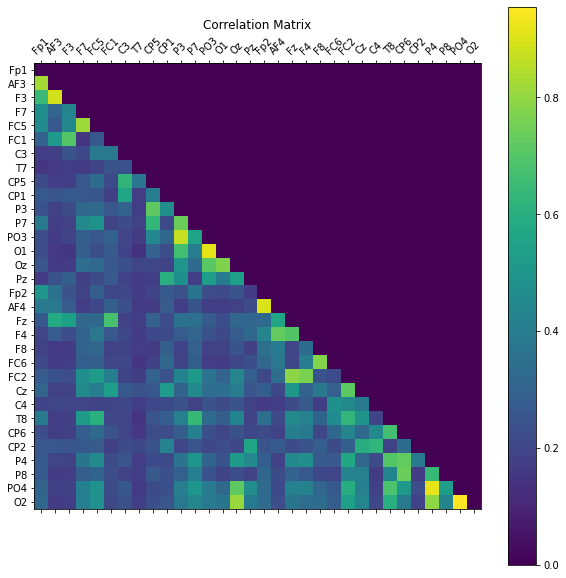

In [75]:
from mne_connectivity import spectral_connectivity_epochs
import matplotlib.pyplot as plt

print(epochs_csd._data[:12].shape)
con = spectral_connectivity_epochs(epochs_csd._data[:12],names=epochs_csd.ch_names, sfreq=epochs_csd.info['sfreq'], n_jobs=1, faverage=True)

f = plt.figure(figsize=(10, 10))
plt.matshow(con.get_data('dense'), fignum=f.number)
plt.xticks(range(len(con.names)), con.names, rotation=45)
plt.yticks(range(len(con.names)), con.names)
cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix');

## 4. Machine Learning